# Kaggle Competition House Prices
By: Rohinesh Ram

# 0. Imports / Functions

In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Scoring used will be negative root mean squared because scikit-learn only implerments maximization

In [339]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statistics

def get_regressor_neg_rms(model, X, y, cv):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms).
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    # Cross validation
    scores = cross_validate(model, X, y, cv=cv, scoring= 'neg_root_mean_squared_error', return_train_score=True)
    
    # get average scores
    train_mean_rms = statistics.mean(scores['train_score'])
    test_mean_rms = statistics.mean(scores['test_score'])
    
    return train_mean_rms, test_mean_rms

In [340]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

# 1. Load the Data

- two data sets from Kaggle, testset and trainset
- also txt of feature descriptions

In [341]:
# Train data set
df_train = pd.read_csv('data_folder/train.csv').set_index('Id')
# Test data set
df_test = pd.read_csv('data_folder/test.csv').set_index('Id')
# Data description
f = open("data_folder/data_description.txt", "r")

# Display each
print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Train Data

In [342]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Test Data

In [343]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 2. Missing Data

## 2.1 Train Set

In [344]:
nan_cols = df_train.columns[df_train.isna().any()]
print("Columns with missing:", nan_cols)

Columns with missing: Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [345]:
print("Number of missing data points:")
df_train.isnull().sum().sort_values(ascending=False).head(10)

Number of missing data points:


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
dtype: int64

Some of the columns with categorical data are labelled 'NA' which pandas interprets as NaN, these data could be missing OR should be 'NA'. It can be assumed that NaN values for categorical features are supposed to be 'NA' because it can be seen that majority of PoolQC, MiscFeature, Alley, etc. data points are missing. The exception is 'Electrical' features which likely are just missing data as there is no category for 'NA'.

**Features missing data**:
- LotFrontage
- MasVnrArea
- GarageYrBlt(NaN if no garage)
- Electrical (probably has missing data)

**Features that might be 'NA'**
- Alley (NA if no alley)
- MasVnrType (None if no masonry)
- BsmtQual (NA if no basement)
- BsmtCond (NA if no basement)
- BsmtExposure (NA if no basement)
- BsmtFinType1 (NA if no basement)
- BsmtFinType2 (NA if no basement)

- FireplaceQu (NA if no fireplace)
- GarageType (NA if no garage)
- GarageFinish (NA if no garage)
- GarageQual (NA if no garage)
- GarageCond (NA if no garage)
- PoolQC (NA if no Pool)
- Fence (NA if no fence)
- MiscFeature (NA if no miscekkabeiys features)

First, rows missing data for numerical features will be removed. Rows with Electrical features missing will be removed. Finally, the columns with categorical data that have NaN will be converted to 'NA'

In [346]:
# remove missing data
df_train = df_train[df_train['LotFrontage'].notna()]
df_train = df_train[df_train['MasVnrArea'].notna()]
df_train = df_train[df_train['GarageYrBlt'].notna()]
df_train = df_train[df_train['Electrical'].notna()]

print("Shape after removing missing data:", df_train.shape)

Shape after removing missing data: (1120, 80)


I thought it was okay to remove the data points with missing values because we still have over 1000 data points to work with.

In [347]:
# replace categorical features
df_train = df_train.fillna('NA')
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


## 2.2 Test Set

In [348]:
df_test.columns[df_test.isna().any()]

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

**Features missing data**:
- MSZoning
- LotFrontage
- Utilities
- Exterior1st
- Exterior2nd
- MasVnrType
- MasVnrrArea
- BsmntFinSF1
- BsmntFinSF2
- BsmntUnfSF
- TotalBsmtSF
- BsmtFullBath
- BsmtHalfBath
- KitchenQual
- Functional
- GarageYrBlt
- GarageCars
- GarageArea
- SaleType

**Features that might be 'NA'**
- Alley
- BsmntQual
- BsmntCond
- BsmntExposure
- BsmtFinType1
- BsmntFinType2
- FirePlaceQu
- GarageType
- GarageFinish
- GarageQual
- GarageCond
- PoolQC
- Fence
- MiscFeature


In [349]:
missing_data = [
    'MSZoning',
    'LotFrontage',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'KitchenQual',
    'Functional',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea',
    'SaleType']

In [350]:
# only keep rows with non missing data
for label in missing_data:
    df_test = df_test[df_test[label].notna()]
df_test.shape

(1139, 79)

In [261]:
# rest are 'NA'
df_test = df_test.fillna('NA')
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NA,IR1,HLS,AllPub,Inside,...,144,0,NA,NA,NA,0,1,2010,WD,Normal


# 3. Prepare Feature matrix and Target Vector

In [290]:
y_train = df_train['SalePrice']
X_train = df_train.loc[:,'MSSubClass':'SaleCondition']
X_test = df_test.loc[:,'MSSubClass':'SaleCondition']

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)
print("X test shape:", X_test.shape)

X train shape: (1120, 79)
y train shape: (1120,)
X test shape: (1139, 79)


# 4. Inspect Data

## 4.1 Distribution of the sales price

Text(0.5, 1.0, 'Distribution of Sales Price')

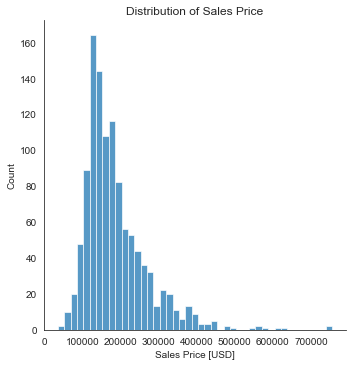

In [221]:
sns.set_style("white")
ax = sns.displot(y_train)
ax.set_xlabels("Sales Price [USD]")
plt.title("Distribution of Sales Price")

In [222]:
y_train.describe()

count      1120.000000
mean     185522.229464
std       83034.490782
min       35311.000000
25%      130875.000000
50%      164800.000000
75%      219500.000000
max      755000.000000
Name: SalePrice, dtype: float64

- Majority of houses sold within the 100K - 300K range
- outliers in the +700K Range

## 4.2 Correlation between features

Correlation between numerical features only

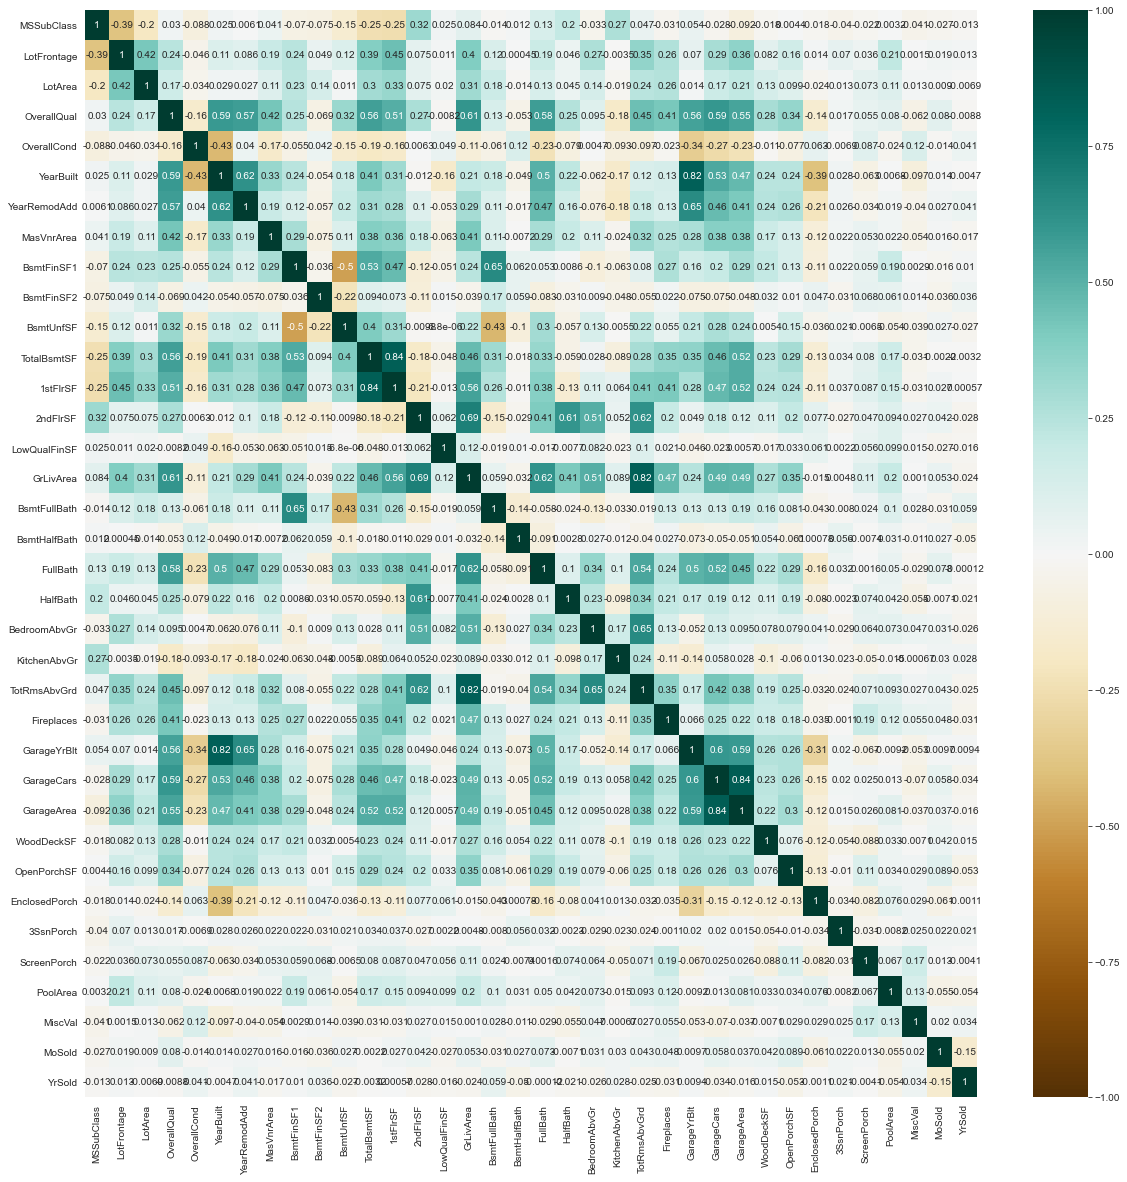

In [223]:
X_corr = X_train.corr()
f = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(X_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

## 4.3 Range of Features

Note: These are all numerical features, but some of these features are actually categorical, e.g. MSSubclass

In [224]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,...,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.00000,1120.000000,1120.000000,1120.000000
mean,56.125000,70.663393,10123.302679,6.213393,5.561607,1972.234821,1985.664286,108.584821,438.791071,44.629464,...,503.047321,92.603571,46.171429,21.864286,3.351786,16.115179,2.93750,23.450000,6.341071,2007.795536
std,41.785256,24.277552,8132.925949,1.380963,1.068582,30.965131,21.025704,189.557855,468.410812,157.893600,...,191.303698,121.922865,64.404019,61.305979,29.785672,57.825646,40.23996,165.832385,2.688756,1.335625
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,160.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7590.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,...,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,5.000000,2007.000000
50%,50.000000,70.000000,9399.000000,6.000000,5.000000,1974.000000,1995.000000,0.000000,374.500000,0.000000,...,484.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.00000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11361.250000,7.000000,6.000000,2003.000000,2005.000000,170.000000,702.500000,0.000000,...,600.250000,168.000000,68.000000,0.000000,0.000000,0.000000,0.00000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,648.00000,2500.000000,12.000000,2010.000000


# 5. Pre-process

We have a mix of numerical, categorical features, and ordinal features, lets find which are which:

**Numerical**: LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

Some of the numerical features are actually categorical and ordinal features

**Categorical**: MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, MiscFeature, SaleType, SaleCondition, MoSold, YrSold 

Features related to quality or condition were considered ordinal because they imply some sort of rank or order, i.e. good quality is better than fair quality.

**Ordinal**: OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, Fence

In [278]:
numerical = 'LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal'
categorical = 'MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, MiscFeature, SaleType, SaleCondition, MoSold, YrSold'
ordinal = 'OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, Fence'

numerical = numerical.split(', ')
categorical = categorical.split(', ')
ordinal = ordinal.split(', ')

print("Number of numerical features:", len(numerical))
print("Number of categorical features:", len(categorical))
print("Number of ordinal features:", len(ordinal))

Number of numerical features: 31
Number of categorical features: 32
Number of ordinal features: 16


## 5.1 Encoding Categorical and Ordinal Features

In [310]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# this is the pre-processor
ct = ColumnTransformer(
    [('onehot', OneHotEncoder(sparse = False,handle_unknown='ignore' ), categorical),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal),
    ('nothing', 'passthrough', numerical)])
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print("Train Shape after pre-process", X_train_trans.shape)

Train Shape after pre-process (1120, 260)


# 6. Model Comparison using CV

Using RandomForestRegressor and GradientBoostingRegressor and 5-fold cross validation to calculate training and validation nRMS in units of USD

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

# instantiate the models with default params
models = [RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]

for model in models:
    model_name = type(model).__name__
    test_score, val_score = get_regressor_neg_rms(model, X_train_trans, y_train, 5)
    print(model_name + "\n  Training nRMS[USD]: {0:.2f}\n  Validation nRMS[USD]: {1:.2f}".format(test_score, val_score))

RandomForestRegressor
  Training nRMS[USD]: -11957.11
  Validation nRMS[USD]: -31771.65
GradientBoostingRegressor
  Training nRMS[USD]: -12991.14
  Validation nRMS[USD]: -27717.49


Error is quite large compared to the actual average house prices ($185,522.22 USD), require hyper-paramter tuning. Note: performance is similar between the two models.

# 7. Find a better Model

Approach: Grid search with CV

## 7.1 RandomForestRegressor

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

param_grid = {
                'n_estimators': [500, 1000, 10000],
                'max_depth': [15, 17, 20, 25]
            }

grid = GridSearchCV(RandomForestRegressor(random_state=64),
                    param_grid,
                    cv=3,
                    scoring='neg_root_mean_squared_error')

grid.fit(X_train_trans, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=64),
             param_grid={'max_depth': [15, 17, 20, 25],
                         'n_estimators': [500, 1000, 10000]},
             scoring='neg_root_mean_squared_error')

In [123]:
print("Best parametars for RFR:",grid.best_params_)
print("Best nRMS: {0:.2f}".format(grid.best_score_))

Best parametars for RFR: {'max_depth': 20, 'n_estimators': 1000}
Best nRMS: -31913.95


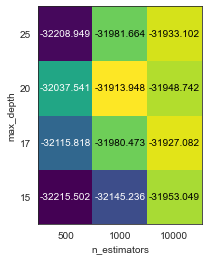

In [120]:
plot_grid_search_results(grid)

Performance of RFR did not improve much.

## 7.2 GradientBoostedRegression

In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
                'n_estimators': [100, 300, 500],
                'learning_rate': [0.01, 0.1, 1.0]
            }

grid_grad = GridSearchCV(GradientBoostingRegressor(random_state=79),
                    param_grid,
                    cv=3,
                    scoring='neg_root_mean_squared_error')

In [144]:
grid_grad.fit(X_train_trans, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=79),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error')

In [145]:
print("Best parametars for RFR:",grid_grad.best_params_)
print("Best nRMS: {0:.2f}".format(grid_grad.best_score_))

Best parametars for RFR: {'learning_rate': 0.1, 'n_estimators': 300}
Best nRMS: -27868.04


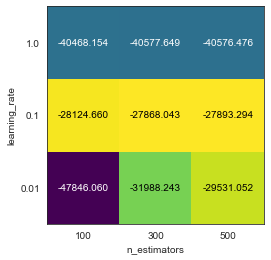

In [146]:
plot_grid_search_results(grid_grad)

Performance increase is marginal, choose to use Gradient boosted with the best params.

# 8. Retrain best Model

Retraining GradientBoostingRegressor from grid search results

In [148]:
print("Best params:", grid_grad.best_estimator_)

Best params: GradientBoostingRegressor(n_estimators=300, random_state=79)


In [151]:
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=79)
model.fit(X_train_trans, y_train)

GradientBoostingRegressor(n_estimators=300, random_state=79)

# 9. Evaluate on Test Data

Kaggle requires 1459 rows to be submitted in the submission file, but I have removed rows where data is missing. To evaluate my results, I will get the sample_submission.csv file and use that as a benchmark. 

In [376]:
y_test = pd.read_csv('data_folder/sample_submission.csv').set_index('Id')
y_test = y_test.loc[list(df_test.index)]

## 9.1 Preprocessing

In [328]:
X_test_trans = ct.transform(X_test)
print("Test shape after pre-prorcess:", X_test_trans.shape)

Test shape after pre-prorcess: (1139, 260)


## 9.2 RMS

In [398]:
# Prediction
y_test_pred = model.predict(X_test_trans)
y_train_pred = model.predict(X_train_trans)

# RMS score
train_rms = mean_squared_error(y_train, y_train_pred, squared=False)
test_rms = mean_squared_error(y_test.values, y_test_pred, squared=False)
print("Train RMS: {0:.2f}".format(train_rms))
print("Test RMS: {0:.2f}".format(test_rms))


Train RMS: 8476.27
Test RMS: 75327.73


Id
1461    169277.052498
1462    187758.393989
1463    183583.683570
1464    179317.477511
1465    150730.079977
            ...      
2912    188506.431412
2913    172917.456816
2916    164788.778231
2917    219222.423400
2919    187741.866657
Name: SalePrice, Length: 1139, dtype: float64

## 9.3 Residual Plot

<AxesSubplot:title={'center':'Residual Plot of Actual - Predicted Price'}, xlabel='Sale Prices [USD]', ylabel='Actual - Predicted Price[USD]'>

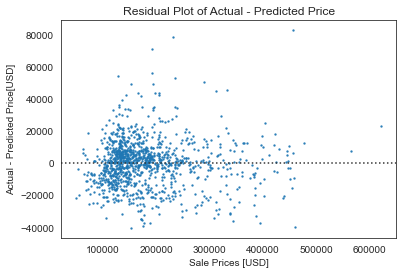

In [405]:

ax = sns.residplot(x=y_test_pred, y= y_test['SalePrice'], scatter_kws={"s": 2})
ax.set_xlabel("Sale Prices [USD]")
ax.set_ylabel("Actual - Predicted Price[USD]")
ax.set_title("Residual Plot of Actual - Predicted Price")
ax